# 0.0) Import das Bibliotecas

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sweetviz as sv
import inflection
import warnings
import math

from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy

from datetime import datetime, timedelta
from IPython.display import Image

### 0.1) Funções Auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline

    warnings.filterwarnings('ignore')
    pd.set_option('display.float_format', '{:.2f}'.format)
    pd.set_option( 'display.expand_frame_repr', False )
    pd.set_option('display.max_columns', 100)
    plt.rcParams['figure.figsize'] = (24, 12)
    plt.rcParams['font.size'] = 24
    sns.set_theme()

In [3]:
jupyter_settings()

### 0.2) Coleta dos Dados

In [4]:
train_raw = pd.read_csv('data/train.csv')
store_raw = pd.read_csv('data/store.csv')

data_raw = train_raw.merge(store_raw, on='Store', how='left')

# 1.0) Descrição dos Dados

In [5]:
df1 = data_raw.copy()

In [6]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.00,9.00,2008.00,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.00,11.00,2007.00,1,13.00,2010.00,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.00,12.00,2006.00,1,14.00,2011.00,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.00,9.00,2009.00,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.00,4.00,2015.00,0,NaN,NaN,NaN


### 1.1) Renomear colunas

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

df1.columns = df1.columns.map(snakecase)

### 1.2) Tipos dos Dados

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3) Valores NAs

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.4) Tratando valores NAs

In [10]:
df1['competition_distance'].fillna(0, inplace=True)
df1['promo_interval'].fillna(0, inplace=True)
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].weekofyear if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

### 1.5) Corrigindo Tipos dos Dados

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.6) Linhas duplicadas

In [12]:
df1.duplicated().sum()

0

### 1.7) Estatísticas de Resumo

In [13]:
num_attr, cat_attr = df1.select_dtypes(include=[int, float]), df1.select_dtypes(exclude=[int, float])

#### 1.7.1) Variáveis Numéricas

In [14]:
num_attr.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.00,558.43,321.91,1.00,280.00,558.00,838.00,1115.00
day_of_week,1017209.00,4.00,2.00,1.00,2.00,4.00,6.00,7.00
sales,1017209.00,5773.82,3849.93,0.00,3727.00,5744.00,7856.00,41551.00
customers,1017209.00,633.15,464.41,0.00,405.00,609.00,837.00,7388.00
open,1017209.00,0.83,0.38,0.00,1.00,1.00,1.00,1.00
promo,1017209.00,0.38,0.49,0.00,0.00,0.00,1.00,1.00
school_holiday,1017209.00,0.18,0.38,0.00,0.00,0.00,0.00,1.00
competition_distance,1017209.00,5415.98,7710.25,0.00,700.00,2320.00,6880.00,75860.00
competition_open_since_month,1017209.00,6.79,3.31,1.00,4.00,7.00,10.00,12.00
competition_open_since_year,1017209.00,2010.32,5.52,1900.00,2008.00,2012.00,2014.00,2015.00


#### 1.7.2) Variáveis Categóricas

In [15]:
cat_attr.describe().T

,count,unique,top,freq,first,last
date,1017209,942,2015-07-31 00:00:00,1115,2013-01-01,2015-07-31
state_holiday,1017209,5,0,855087,NaT,NaT
store_type,1017209,4,a,551627,NaT,NaT
assortment,1017209,3,a,537445,NaT,NaT
promo_interval,1017209.00,4.00,0.00,508031.00,NaT,NaT


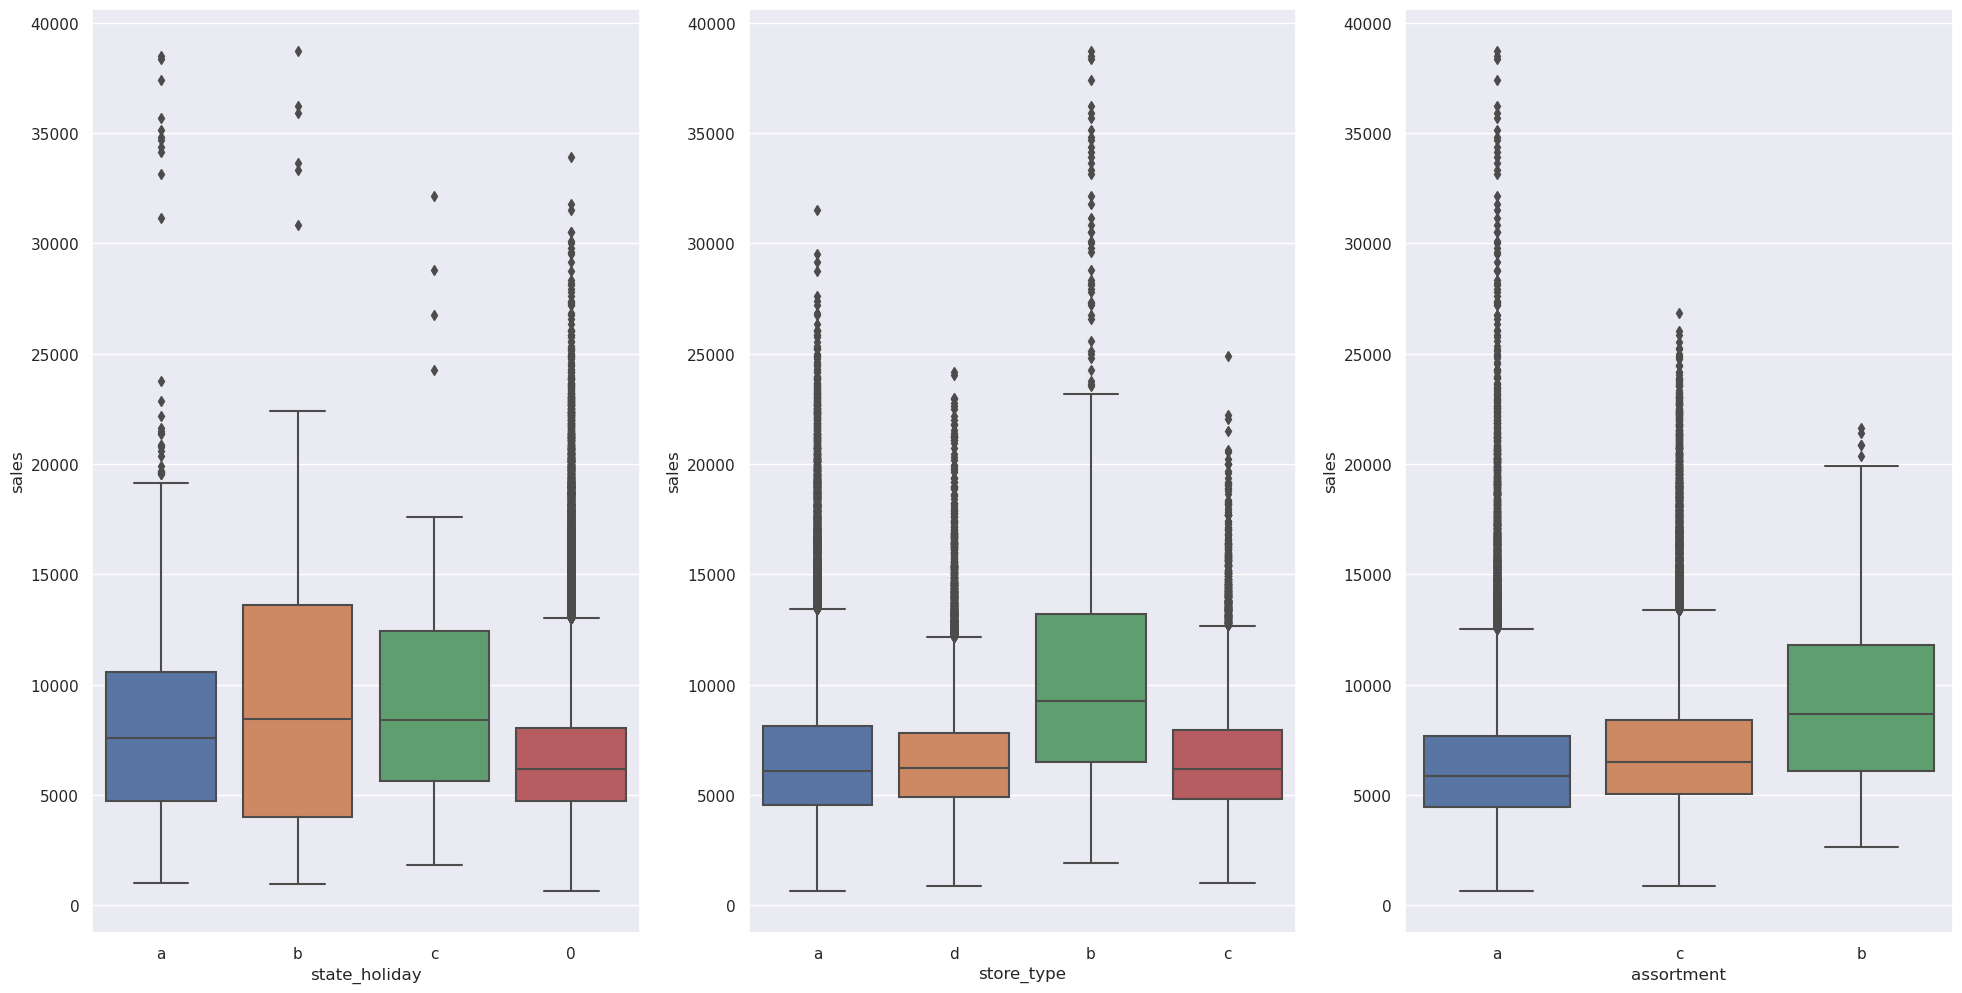

In [16]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

fig, ax = plt.subplots(1, 3)

sns.boxplot(ax=ax[0], data=aux, x='state_holiday', y='sales')
sns.boxplot(ax=ax[1], data=aux, x='store_type', y='sales')
sns.boxplot(ax=ax[2], data=aux, x='assortment', y='sales')

plt.show()

# 2.0) Feature Engineering

In [17]:
df2 = df1.copy()

### 2.1) Mindmap de Hipóteses

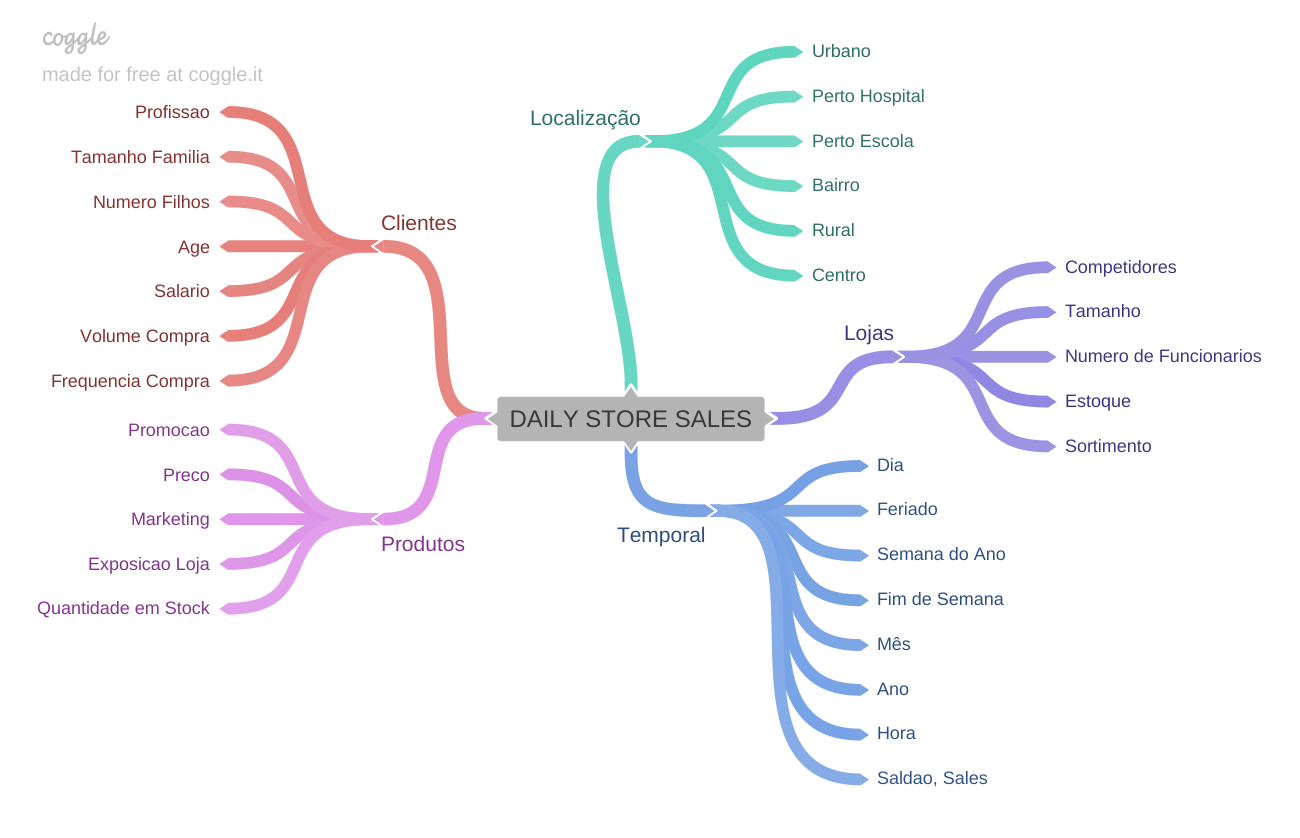

In [18]:
Image('img/DAILY_STORE_SALES.png')

### 2.2) Criação das Hipóteses

#### 2.2.1. Hipoteses Entidade1
1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.
#### 2.2.2. Hipoteses Entidade2
1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.
#### 2.2.3. Hipoteses Entidade3
1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.3) Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

### 2.4) Feature Engineering

In [19]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# assortment
assortment_map = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df2['assortment'] = df2['assortment'].map(assortment_map)

# state_holiday
state_holiday_map = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', 0: 'None'}
df2['state_holiday'] = df2['state_holiday'].map(state_holiday_map)

# competition_since
df2['competition_time_month'] = df2.apply(lambda x: (x['date'] - datetime(year=x['competition_open_since_year'], \
    month=x['competition_open_since_month'], day=1)).days / 30, axis=1).astype(int)

# promo_time_week
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.strptime( x + '-1', '%Y-%W-%w' ) - timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

# is_promo
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df2['month_abbr'] = df2['month'].map(month_map)

df2['is_promo'] = df2.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 \
    if x['month_abbr'] in x['promo_interval'].split(',') else 0, axis=1)

# 3.0) Filtragem de Variáveis

In [48]:
df3 = df2.copy()

### 3.1) Filtragem das Linhas

In [49]:
df3 = df3.loc[(df3['open'] == 1) & (df3['sales'] > 0)]

### 3.2) Seleção das Colunas

In [50]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_abbr', 'promo_since']

df3.drop(columns=cols_drop, inplace=True)

# 4.0) Análise Exploratória de Dados

In [51]:
df4 = df3.copy()

### 4.1) Análise Univariada

In [ ]:
advert_report = sv.analyze(df4)

#display the report
advert_report.show_html('Advertising.html')

#### 4.1.2) Variável Target

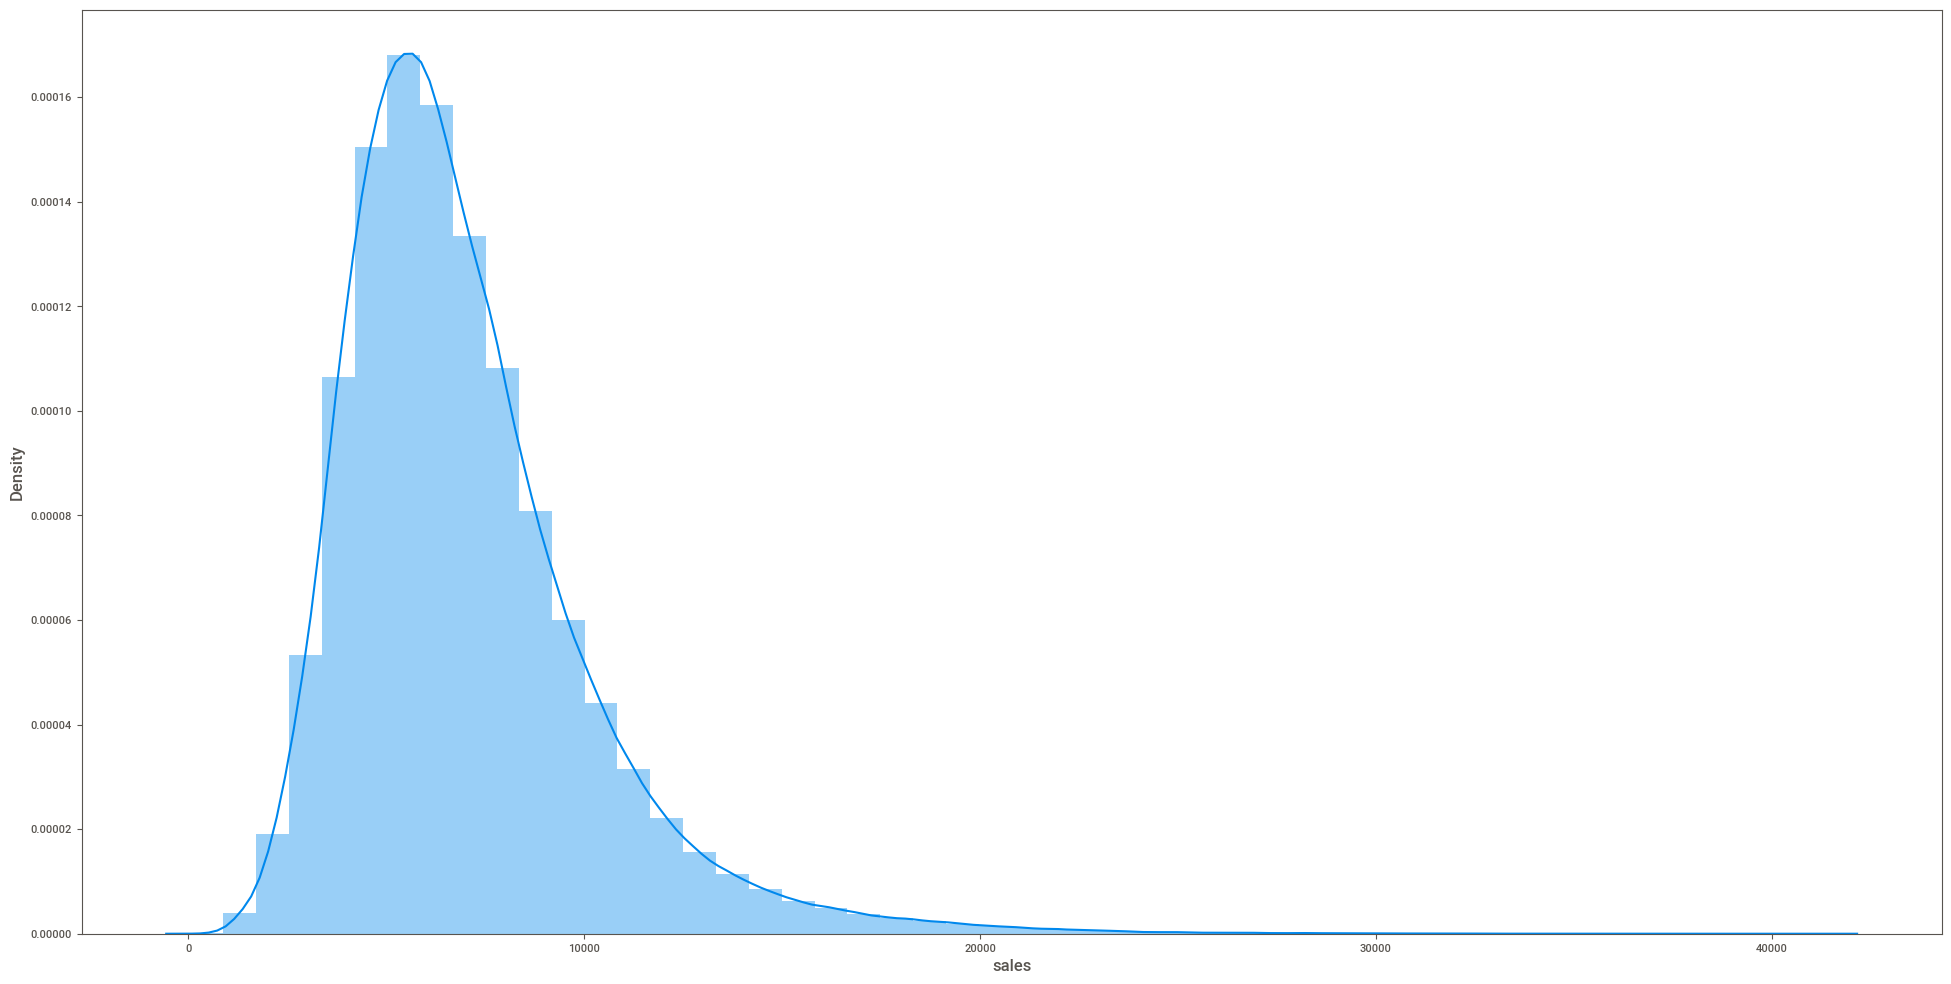

In [53]:
sns.distplot(df4['sales']);

plt.show()

### 4.2) Análise Bivariada

In [54]:
# Está no notebook principal

### 4.3) Análise Multivariada

#### 4.3.1) Variáveis Numéricas

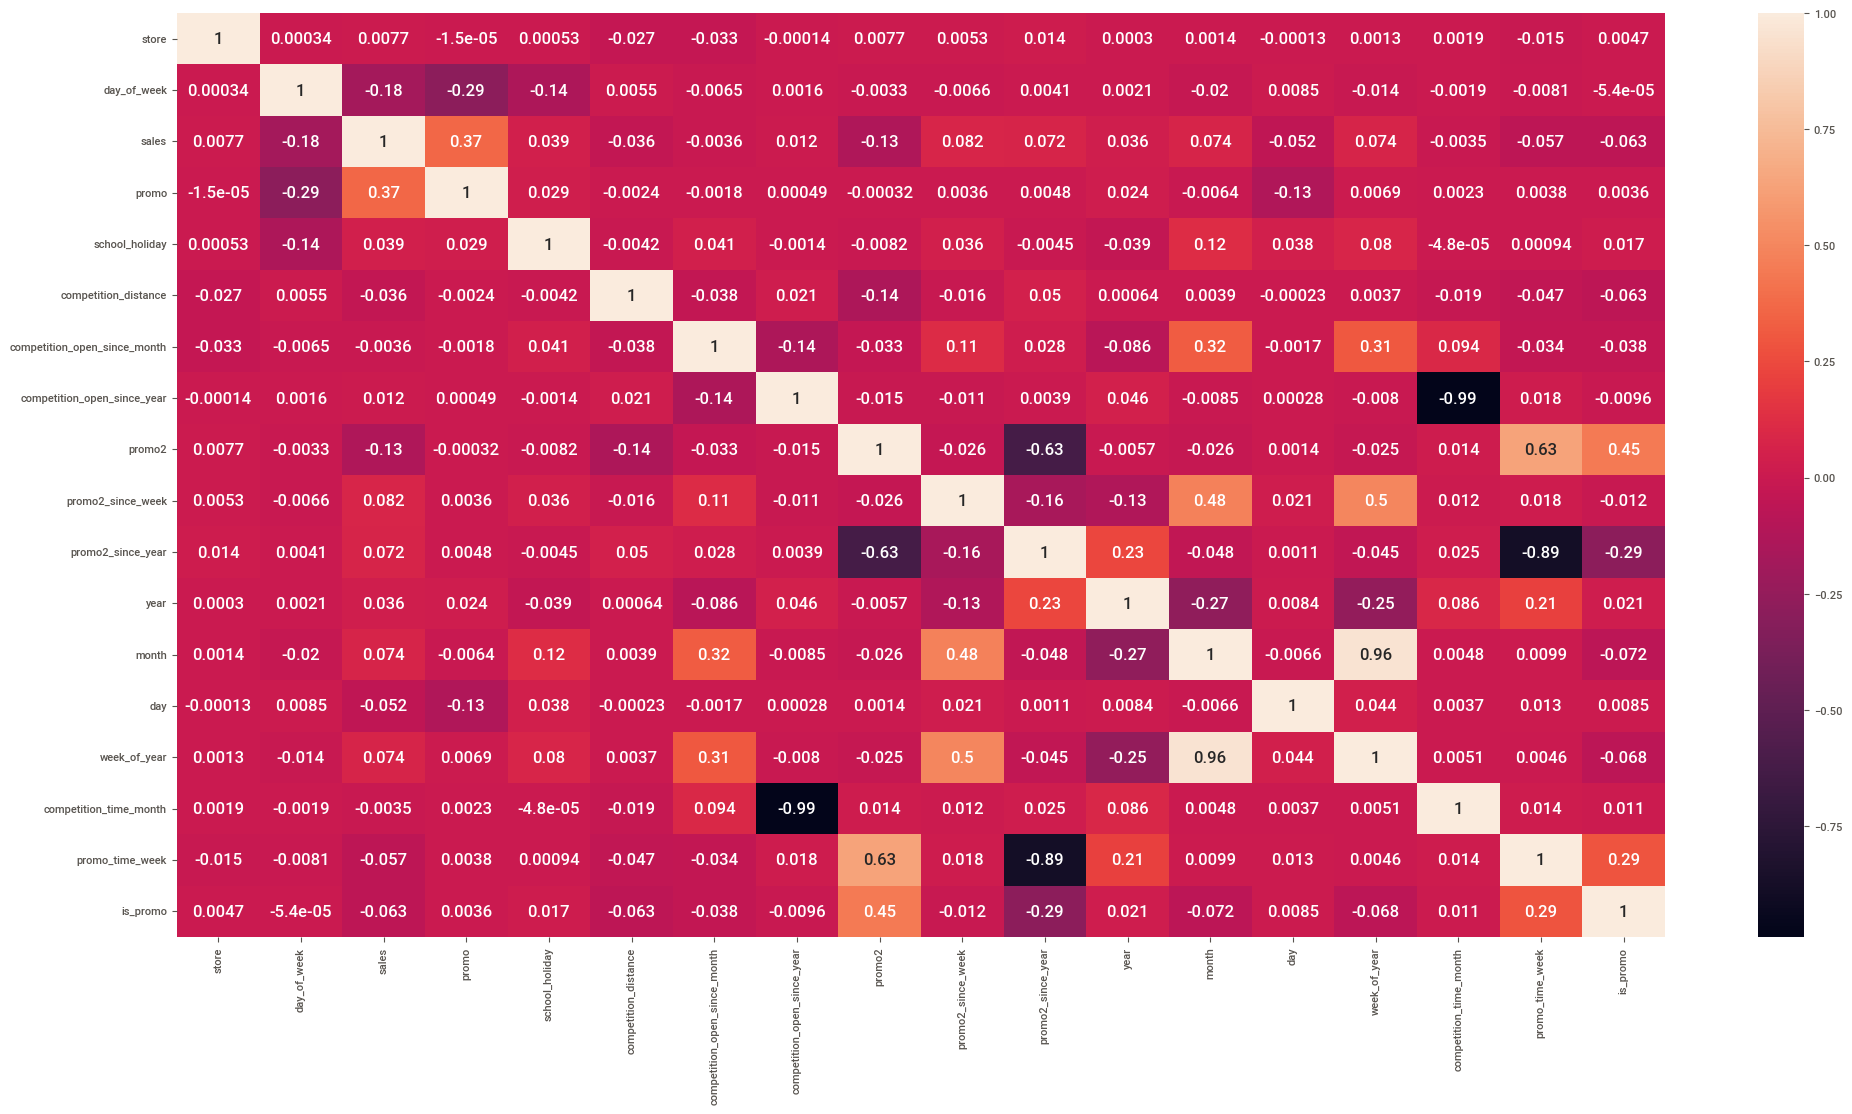

In [55]:
corr = df4.select_dtypes(include=[float, int]).corr(method='pearson')
sns.heatmap(corr, annot=True);

# 5.0) Preparação dos Dados

In [56]:
df5 = df4.copy()

### 5.1) Normalização

In [57]:
# Não necessário para este conjunto de dados

### 5.2) Rescaling

In [58]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

### 5.3) Transformações

#### 5.3.1) Encoding

In [59]:
# state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment
assortment_dict = {'basic': 1, 'extra': 1, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2) Transformação da variável Target

In [60]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.3) Transformação de Natureza

In [61]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6) Seleção de Features

In [62]:
df6 = df5.copy()

### 6.1) Split dos dados em treino e teste

In [63]:
# train data
X_train = df6.loc[df6['date'] < '2015-06-19', :]
y_train = X_train['sales']

# test data
X_test = df6.loc[df6['date'] >= '2015-06-19', :]
y_test = X_test['sales']

print(f"Train Data Min Date: {X_train.date.min()}")
print(f"Train Data Max Date: {X_train.date.max()}")

print(f"Test Data Min Date: {X_test.date.min()}")
print(f"Test Data Max Date: {X_test.date.max()}")

Train Data Min Date: 2013-01-01 00:00:00
Train Data Max Date: 2015-06-18 00:00:00
Test Data Min Date: 2015-06-19 00:00:00
Test Data Max Date: 2015-07-31 00:00:00


### 6.2) Seleção de features com Boruta

#### 6.2.1) Melhores features selecionadas pelo Boruta

### 6.3) Seleção de features manual

In [64]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7) Treinamento de algoritmos de ML

In [65]:
df7 = df6.copy()

In [66]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

### 7.1) Modelo Baseline

### 7.2) Regressão Linear

### 7.3) Regressão Lasso

### 7.4) Random Forest Regressor

### 7.5) XGBoost Regressor

### 7.6) Compare Model's Performance

#### 7.6.1. Single Performance

#### 7.6.2. Real Performance - Cross Validation

# 8.0) Tunagem de Híper-Parâmetros

### 8.1) Random Search

### 8.2) Final Model

# 9.0) Tradução e Interpretação do Erro

### 9.1) Business Performance

### 9.2) Total Performace

### 9.3) Machine Learning Performance

# 10) Deploy do Modelo em Produção

### 10.1) Rossmann Class

### 10.2) API Handler

### 10.3) API Tester